#### Import Libraries

In [1]:
import os 
import sys
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'ConvLSTM_PyTorch_master'))
import numpy as np 
import pandas as pd
import xarray as xr 
import matplotlib.pyplot as plt 
import seaborn as sns
import cartopy.crs as ccrs
from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
import torchmetrics.image as t_metrics 

from data_standarization import mean_std_scaler

from net_params_auto import convlstm_encoder_params, convlstm_decoder_params
from encoder import Encoder
from decoder import Decoder
from model import ED

import loss_functions

#### Upload data

In [2]:
frames_predict = 12
batch_size = 8
num_layers = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class ERA5_dataset(torch.utils.data.Dataset):

    def __init__(self, frame = None):
        super(ERA5_dataset, self).__init__()

        # Define the path
        self.data_path = os.path.join(os.getcwd(), '..', '..', 'input_data', 'hourly')

        # Read the data
        self.data = xr.open_dataset(os.path.join(self.data_path, 'valid_data_hourly_m_s_2020_2020.nc'))['ws']

        #I order the coordinates
        coords = self.data.coords
        self.original_coords = {'time': coords['time'], 'latitude': coords['latitude'], 'longitude': coords['longitude']}
        self.dims = ["time", "latitude", "longitude"]
        
        self.data = np.array(self.data)
        self.data = torch.from_numpy(self.data).float()

        self.dataset_spatial_size = self.data.shape[-1]

        self.stats = xr.open_dataset(os.path.join(self.data_path, 'statistics_train_ds_per_pixel.nc'))
        self.mean = self.stats["mean"]
        self.std = self.stats["std"]

        self.mean = np.array(self.mean)
        self.mean = torch.from_numpy(self.mean).float()

        self.std = np.array(self.std)
        self.std = torch.from_numpy(self.std).float()
        
        self.data = mean_std_scaler(self.data, self.mean, self.std)
        
        #chunkify: That is, reshape data in an array where each element are a 3D cube of 12x144x144 
        # I calcule data.shape[0]/12)*12 so that the number of selected data are divisible by 12
        self.data = self.data[:int(self.data.shape[0]/frames_predict)*frames_predict].reshape((int(self.data.shape[0]/frames_predict), frames_predict, self.dataset_spatial_size, self.dataset_spatial_size))

        # (inputs are given as data[:-1], targets as data[1:])
        self.inputs = self.data[:-1]
        self.targets = self.data[1:]

        if frame != None:
            permuted_indices = torch.randperm(self.inputs.shape[0])
            self.inputs[:, 11 + frame, :, :] = self.inputs[permuted_indices, 11 + frame, :, :]

        # I do the same transformations for the coordinats, specifically the time coordinate
        self.orig_coords_time = np.array(self.original_coords["time"])
        self.orig_coords_lon = np.array(self.original_coords["longitude"])
        self.orig_coords_lat = np.array(self.original_coords["latitude"])

        self.new_coords_time = self.orig_coords_time[:int(self.orig_coords_time.shape[0] / frames_predict) * frames_predict].reshape((int(self.orig_coords_time.shape[0] / frames_predict), frames_predict))

        input_coords_time = self.new_coords_time[:-1]
        target_coords_time = self.new_coords_time[1:]

        input_coords_time = input_coords_time.reshape((int(input_coords_time.shape[0] * frames_predict)))
        target_coords_time = target_coords_time.reshape((int(target_coords_time.shape[0] * frames_predict)))

        self.input_coords = {'time': input_coords_time, 'latitude': coords['latitude'], 'longitude': coords['longitude']}
        self.target_coords = {'time': target_coords_time, 'latitude': coords['latitude'], 'longitude': coords['longitude']}

        #print('input/target division done.')

        self.dataset = TensorDataset(*(self.inputs, self.targets, self.targets))
            
    def __getitem__(self, index):
        input = self.dataset.tensors[0][index]
        target = self.dataset.tensors[1][index]
        sup = self.dataset.tensors[2][index]
        
        return input, target, sup, index
    
    #return dataset length
    def __len__(self):
        return len(self.dataset)

In [4]:
#data = ERA5_dataset(frame=-11)
#dataLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=20)

#### Uplaod Model

In [5]:
model_path = os.path.join(os.getcwd(), '..', '..', 'experiments', 'convlstm_mae_4_PerPixel_mean-std_hourly_100_epochs_FP12', 'models', 'ckpt')

In [6]:
def load_model():

    encoder_params = convlstm_encoder_params(num_layers, input_len=frames_predict, device=device)
    decoder_params = convlstm_decoder_params(num_layers, output_len=frames_predict, device=device)

    encoder = Encoder(encoder_params[0], encoder_params[1]).to(device)
    decoder = Decoder(decoder_params[0], decoder_params[1], num_layers).to(device)
    
    net = ED(encoder, decoder)

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    
    net.to(device)

    torch.cuda.empty_cache()

    # Loading model
    model_info = torch.load(os.path.join(model_path, 'checkpoint_50.pth.tar'), map_location=device)
        
    net.load_state_dict(model_info['state_dict'])

    return net 

In [7]:
model = load_model()
print('ConvLSTM Model loaded successfully')

/tmp/ipykernel_79458/99982798.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_info = torch.load(os.path.join(model_path, 'checkpoint_50.pth.tar'), map_location=de

ConvLSTM Model loaded successfully


#### Metrics functions

In [8]:
def get_metrics(preds, targets, spain_mask, frame):
    
    metric_dict = {}

    metrics = ['l1Error', 'l2Error', 'Bias_time', 'Bias_space', 'Corr_time', 'Corr_space', 'RMSE_time', 'RMSE_space']#, 'StructuralSimilarityIndexMeasure', 'UniversalImageQualityIndex']

    metric_settings = {
        'l1Error': {},
        'l2Error': {},
        'Bias_time': {},
        'Bias_space': {},
        'Corr_time': {},
        'Corr_space': {},
        'RMSE_time': {},
        'RMSE_space': {},
        'StructuralSimilarityIndexMeasure': {'torchmetric_settings': {}},
        'UniversalImageQualityIndex': {'torchmetric_settings': {}},
        'FrechetInceptionDistance': {'torchmetric_settings': {}},
        'KernelInceptionDistance': {'torchmetric_settings': {}}
    }

    for metric in metrics:

        #print('Calculating {}...'.format(metric))

        settings = metric_settings[metric]

        spain_mask_bool = True

        if 'l1Error' in metric:
            
            l1_loss_t, l1_loss_spain = compute_loss(preds, targets, nn.L1Loss(reduction='mean'), spain_mask, spain_mask_bool)

            metric_dict[f'{frame}/l1Error_total'] = l1_loss_t
            if spain_mask_bool:
                metric_dict[f'{frame}/l1Error_spain'] = l1_loss_spain

        elif 'l2Error' in metric:
            
            l2_loss_t, l2_loss_spain = compute_loss(preds, targets, nn.MSELoss(reduction='mean'), spain_mask, spain_mask_bool)
            metric_dict[f'{frame}/l2Error_total'] = l2_loss_t
            if spain_mask_bool:
                metric_dict[f'{frame}/l2Error_spain'] = l2_loss_spain

        elif 'Bias_time' in metric:
            
            bias_map_time, bias_map_time_spain, bias_time, bias_time_spain = compute_bias_time(preds, targets, spain_mask, spain_mask_bool)
            metric_dict[f'{frame}/Bias_map_time'] = bias_map_time
            metric_dict[f'{frame}/Bias_time'] = bias_time
            if spain_mask_bool:
                metric_dict[f'{frame}/Bias_map_time_spain'] = bias_map_time_spain
                metric_dict[f'{frame}/Bias_time_spain'] = bias_time_spain

        elif 'Bias_space' in metric:
            
            bias_map_space, bias_map_space_spain, bias_space, bias_space_spain = compute_bias_space(preds, targets, spain_mask, spain_mask_bool)

            metric_dict[f'{frame}/Bias_map_space'] = bias_map_space
            metric_dict[f'{frame}/Bias_space'] = bias_space
            if spain_mask_bool:
                metric_dict[f'{frame}/Bias_map_space_spain'] = bias_map_space_spain
                metric_dict[f'{frame}/Bias_space_spain'] = bias_space_spain

        elif 'Corr_time' in metric:
            
            correlation_map_time, correlation_map_time_spain, correlation_time, correlation_time_spain = compute_corr_time(preds, targets, spain_mask, spain_mask_bool)

            metric_dict[f'{frame}/Corr_map_time'] = correlation_map_time
            metric_dict[f'{frame}/Corr_time'] = correlation_time
            if spain_mask_bool:
                metric_dict[f'{frame}/Corr_map_time_spain'] = correlation_map_time_spain
                metric_dict[f'{frame}/Corr_time_spain'] = correlation_time_spain

        elif 'Corr_space' in metric:
            
            correlation_map_space, correlation_map_space_spain, correlation_space, correlation_space_spain = compute_corr_space(preds, targets, spain_mask, spain_mask_bool)

            metric_dict[f'{frame}/Corr_map_space'] = correlation_map_space
            metric_dict[f'{frame}/Corr_space'] = correlation_space
            if spain_mask_bool:
                metric_dict[f'{frame}/Corr_map_space_spain'] = correlation_map_space_spain
                metric_dict[f'{frame}/Corr_space_spain'] = correlation_space_spain


        elif 'RMSE_time' in metric:
            
            rmse_map_time, rmse_map_time_spain, rmse_time, rmse_time_spain = compute_rmse_time(preds, targets, spain_mask, spain_mask_bool)

            metric_dict[f'{frame}/RMSE_map_time'] = rmse_map_time
            metric_dict[f'{frame}/RMSE_time'] = rmse_time
            if spain_mask_bool:
                metric_dict[f'{frame}/RMSE_map_time_spain'] = rmse_map_time_spain
                metric_dict[f'{frame}/RMSE_time_spain'] = rmse_time_spain

        elif 'RMSE_space' in metric:
            
            rmse_map_space, rmse_map_space_spain, rmse_space, rmse_space_spain = compute_rmse_space(preds, targets, spain_mask, spain_mask_bool)

            metric_dict[f'{frame}/RMSE_map_space'] = rmse_map_space
            metric_dict[f'{frame}/RMSE_space'] = rmse_space
            if spain_mask_bool:
                metric_dict[f'{frame}/RMSE_map_space_spain'] = rmse_map_space_spain
                metric_dict[f'{frame}/RMSE_space_spain'] = rmse_space_spain


        else:
            metric_outputs = calculate_metric(metric, preds, targets, torchmetrics_settings=settings['torchmetric_settings'])
            metric_dict[f'{frame}/{metric}'] = metric_outputs

            #if len(metric_outputs) > 1:
            #    for k, metric_name in enumerate(settings['outputs']):
            #        metric_dict[f'{frame}/{metric}_{metric_name}'] = metric_outputs[k]
            #else:
            #    metric_dict[f'{frame}/{metric}'] = metric_outputs[0]

    return metric_dict

def compute_loss(pred, target, loss_fn, spain_mask, spain_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    loss_total = loss_fn(pred, target).item()

    if spain_bool:
        # Create a mask to ignore NaN values
        mask = ~torch.isnan(spain_mask.unsqueeze(0).expand_as(pred))

        # Apply masks to vectors
        pred_spain = pred[mask]
        target_spain = target[mask]

        loss_spain = loss_fn(pred_spain, target_spain).item()

    return loss_total, loss_spain

def compute_bias_time(pred, target, mask_spain, spain_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    bias_map_time = torch.mean(pred - target, dim=0)

    # Máscara para España
    if spain_bool:
        bias_map_time_spain = torch.where(mask_spain.isnan(), float('nan'), bias_map_time)
    else:
        bias_map_time_spain = torch.zeros_like(bias_map_time)

    return (bias_map_time, bias_map_time_spain, torch.nanmean(bias_map_time).item(), torch.nanmean(bias_map_time_spain).item())

def compute_bias_space(pred, target, mask_spain, spain_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # First, the spatial dimension (lat and lon) are planned. Dimensions now is time, lat * lon
    pred_flattened = pred.view(pred.shape[0], -1)
    target_flattened = target.view(pred.shape[0], -1)

    # Calculation of the bias
    bias_map_space = torch.mean(pred_flattened - target_flattened, dim=1)

    # Spain_mask
    if spain_bool:
        mask = ~torch.isnan(mask_spain.flatten())
        pred_spain = pred_flattened[:, mask]
        target_spain = target_flattened[:, mask]  

        bias_map_space_spain = torch.mean(pred_spain - target_spain, dim=1)
                
    return bias_map_space, bias_map_space_spain, torch.nanmean(bias_map_space).item(), torch.nanmean(bias_map_space_spain).item()
  
def compute_corr_time(pred, target, mask_spain, spain_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # Calculation of the Correlation: 
    # r = Cov(X, Y)/(sigma_x * sigma_y)
    
    # Calcule the means
    pred_mean  = torch.mean(pred, dim=0)
    target_mean = torch.mean(target, dim=0)

    # Calcule the Covariance and standard deviations
    covariance = torch.mean(pred * target, dim=0) - pred_mean * target_mean
    pred_var = torch.mean(pred ** 2, dim=0) - pred_mean ** 2
    target_var = torch.mean(target ** 2, dim=0) - target_mean ** 2

    # Correlation
    corr_map_time = covariance / (torch.sqrt(pred_var) * torch.sqrt(target_var))

    # Check for pixels with standard variance approximately 0, i.e., correlation values >1 or <-1
    corr_map_time[corr_map_time>1] = float('nan')
    corr_map_time[corr_map_time<-1] = float('nan')

    # Spain_mask
    if spain_bool:
        corr_map_time_spain = torch.where(mask_spain.isnan(), float('nan'), corr_map_time)
    else:
        corr_map_time_spain = torch.zeros_like(corr_map_time)

    return corr_map_time, corr_map_time_spain, torch.nanmean(corr_map_time).item(), torch.nanmean(corr_map_time_spain).item()

def compute_corr_space(pred, target, mask_spain, spain_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # First, the spatial dimension (lat and lon) are planned. Dimensions now is time, lat * lon
    pred_flattened = pred.view(pred.shape[0], -1)
    target_flattened = target.view(pred.shape[0], -1)

    # Calculation of the Means
    pred_mean = torch.mean(pred_flattened, dim=1)
    target_mean = torch.mean(target_flattened, dim=1)

    # Calculation of covariance and standard deviations
    covariance = torch.mean(pred_flattened * target_flattened, dim=1) - pred_mean * target_mean
    pred_var = torch.mean(pred_flattened ** 2, dim=1) - pred_mean ** 2
    target_var = torch.mean(target_flattened ** 2, dim=1) - target_mean ** 2

    # Correlation
    corr_map_space = covariance / (torch.sqrt(pred_var) * torch.sqrt(target_var))
    corr_map_space[torch.isnan(corr_map_space)] = 0

    # Spain_mask
    if spain_bool:
        mask = ~torch.isnan(mask_spain.flatten())
        pred_spain = pred_flattened[:, mask]
        target_spain = target_flattened[:, mask]

        # Calculation of the Means
        pred_mean_spain = torch.mean(pred_spain, dim=1)
        target_mean_spain = torch.mean(target_spain, dim=1)

        # Calculation of covariance and standard deviations
        covariance_spain = torch.mean(pred_spain * target_spain, dim=1) - pred_mean_spain * target_mean_spain
        pred_var_spain = torch.mean(pred_spain ** 2, dim=1) - pred_mean_spain ** 2
        target_var_spain = torch.mean(target_spain ** 2, dim=1) - target_mean_spain ** 2

        # Correlation
        corr_map_space_spain = covariance_spain / (torch.sqrt(pred_var_spain) * torch.sqrt(target_var_spain))
        corr_map_space_spain[torch.isnan(corr_map_space_spain)] = 0    
                
    return corr_map_space, corr_map_space_spain, torch.nanmean(corr_map_space).item(), torch.nanmean(corr_map_space_spain).item()

def compute_rmse_time(pred, target, mask_spain, spain_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # Calculation of the Full RMSE
    rmse_map_time = torch.sqrt(torch.mean((pred - target) ** 2, dim=0))

    # Spain_mask
    if spain_bool:
        rmse_map_time_spain = torch.where(mask_spain.isnan(), float('nan'), rmse_map_time)
    else:
        rmse_map_time_spain = torch.zeros_like(rmse_map_time)

    return rmse_map_time, rmse_map_time_spain, torch.nanmean(rmse_map_time).item(), torch.nanmean(rmse_map_time_spain).item() 

def compute_rmse_space(pred, target, mask_spain, spain_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # First, the spatial dimension (lat and lon) are planned. Dimensions now is time, lat * lon
    pred_flattened = pred.view(pred.shape[0], -1)
    target_flattened = target.view(pred.shape[0], -1)

    # Calculation of the RMSE
    rmse_map_space = torch.sqrt(torch.mean((pred_flattened - target_flattened) ** 2, dim=1))

    # Spain_mask
    if spain_bool:
        mask = ~torch.isnan(mask_spain.flatten())
        pred_spain = pred_flattened[:, mask]
        target_spain = target_flattened[:, mask]

        rmse_map_space_spain = torch.sqrt(torch.mean((pred_spain - target_spain) ** 2, dim=1))
                
    return rmse_map_space, rmse_map_space_spain, torch.nanmean(rmse_map_space).item(), torch.nanmean(rmse_map_space_spain).item()

def calculate_metric(name_expr, pred, target, torchmetrics_settings={}, part=5000):

    metric_str = [m for m in t_metrics.__dict__.keys() if (name_expr == m)]

    if len(metric_str) == 0:
        metric_str = [m for m in t_metrics.__dict__.keys() if (name_expr in m)]
        if len(metric_str) > 1:
            warnings.warn('found multiple hits for metric name {}. Will use {}'.format(name_expr, metric_str[0]))

    assert len(metric_str) > 0, 'metric {} not found in torchmetrics.image. Maybe torch-fidelity is missing.'.format(name_expr)

    metric = t_metrics.__dict__[metric_str[0]](**torchmetrics_settings)

    total_sum = 0.0
    total_batches = 0

    for i in range(0, pred.size(0), part):

        batch_preds = pred[i:min(i + part, pred.size(0))]
        batch_targets = target[i:min(i + part, pred.size(0))]
    
        with torch.no_grad():
            value = metric(batch_preds.unsqueeze(1), batch_targets.unsqueeze(1)).item()
            total_sum += value
            total_batches += 1
    
    del batch_preds, batch_targets

    return total_sum/total_batches

#### Load the spanish map

In [9]:
# Define the path
data_path = os.path.join(os.getcwd(), '..', '..', 'input_data', 'hourly')

# Read the data
spain_mask = xr.open_dataset(os.path.join(data_path, 'mask_spain.nc'))["mask_spain"].values
spain_mask = torch.tensor(spain_mask).to('cpu')

#### Run Test

In [10]:
def test(model, dataLoader, data):

    # Define empty lists to keep the predictions
    target_coll = torch.zeros((len(data), frames_predict, data.dataset_spatial_size, data.dataset_spatial_size), device='cpu')
    pred_coll = torch.zeros((len(data), frames_predict, data.dataset_spatial_size, data.dataset_spatial_size), device='cpu')

    loss_aver_test = 0

    model.eval()
    with torch.no_grad():
    
        t = tqdm(dataLoader, leave=True, total=len(dataLoader))
        
        for i, (inputVar, targetVar, _, indices) in enumerate(t):

            #t.set_description("Epoch = {}".format(i))
            
            inputs = inputVar.to(device)
            targets = targetVar.to(device) 
                          
            # unsqueeze(2): Add the dimension of channel, needed for the model: from (B, 12, H, W) to (B, 12, 1, H, W). 
            # squeeze(): Remove an unnecessary dimension of channels (channel = 1): from (B, 12, 1, H, W) to (B, 12, H, W). 
            preds = model(inputs.unsqueeze(2)).squeeze(2)

            #loss = loss_functions.choose_loss(preds, targets, x, args)#.requires_grad_()
            loss = torch.abs(preds - targets).mean() 

            loss_aver_test += loss.item() #/ preds.shape[0]

            # save data according to the correct index
            for j, index in enumerate(indices):
                   
                #saving variables
                #input_coll[index] = inputs[j].detach().cpu()
                target_coll[index] = targets[j].detach().cpu()
                pred_coll[index] = preds[j].detach().cpu()

            t.set_postfix({'TestLoss': '{:.6f}'.format(loss_aver_test)})
            
            del inputs, targets, preds, indices

        loss_aver_test /= (i+1)

        torch.cuda.empty_cache()

    return target_coll, pred_coll, loss_aver_test

#### Individual examples

#### Base model

In [11]:
data = ERA5_dataset()
dataLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=20)

In [12]:
target, pred, loss_run = test(model, dataLoader, data)

print()
print('Base model')
print('Test Loss: {:.3f}'.format(loss_run))
print()

# Reshape data
targets = target.reshape(target.shape[0] * target.shape[1], target.shape[2], target.shape[3])
preds = pred.reshape(pred.shape[0] * pred.shape[1], pred.shape[2], pred.shape[3])

# Unstandarize data
targets = targets * data.std + data.mean
preds = preds * data.std + data.mean

# Calcule metrics
metrics = get_metrics(preds, targets, spain_mask, 1)

for key, val in metrics.items():
    if "map" not in key:
        print('{}: {:.3f}'.format(key, val))

torch.cuda.empty_cache()

del target, targets, pred, preds, loss_run, metrics

100%|██████████| 92/92 [00:23<00:00,  3.87it/s, TestLoss=30.550799]



Base model
Test Loss: 0.332

1/l1Error_total: 0.663
1/l1Error_spain: 0.433
1/l2Error_total: 1.033
1/l2Error_spain: 0.396
1/Bias_time: -0.001
1/Bias_time_spain: -0.010
1/Bias_space: -0.001
1/Bias_space_spain: -0.010
1/Corr_time: 0.878
1/Corr_time_spain: 0.888
1/Corr_space: 0.922
1/Corr_space_spain: 0.851
1/RMSE_time: 0.937
1/RMSE_time_spain: 0.614
1/RMSE_space: 0.939
1/RMSE_space_spain: 0.570


#### Permuted data 

In [13]:
del data, dataLoader

frame = 0 # from -11 to 0
data = ERA5_dataset(frame=frame)
dataLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=20)

In [14]:
target, pred, loss_run = test(model, dataLoader, data)

print()
print('Base model')
print('Test Loss: {:.3f}'.format(loss_run))
print()

# Reshape data
targets = target.reshape(target.shape[0] * target.shape[1], target.shape[2], target.shape[3])
preds = pred.reshape(pred.shape[0] * pred.shape[1], pred.shape[2], pred.shape[3])

# Unstandarize data
targets = targets * data.std + data.mean
preds = preds * data.std + data.mean

# Calcule metrics
metrics = get_metrics(preds, targets, spain_mask, 1)

for key, val in metrics.items():
    if "map" not in key:
        print('{}: {:.3f}'.format(key, val))

torch.cuda.empty_cache()

del target, targets, pred, preds, loss_run, metrics

100%|██████████| 92/92 [00:24<00:00,  3.79it/s, TestLoss=95.553973]



Base model
Test Loss: 1.039

1/l1Error_total: 2.146
1/l1Error_spain: 1.397
1/l2Error_total: 8.930
1/l2Error_spain: 3.471
1/Bias_time: 0.230
1/Bias_time_spain: 0.046
1/Bias_space: 0.230
1/Bias_space_spain: 0.046
1/Corr_time: -0.009
1/Corr_time_spain: -0.006
1/Corr_space: 0.562
1/Corr_space_spain: 0.346
1/RMSE_time: 2.706
1/RMSE_time_spain: 1.805
1/RMSE_space: 2.878
1/RMSE_space_spain: 1.712


#### Run all data frames

In [15]:
all_metrics = {}

print('Run base model one...')

# Upload the data
data = ERA5_dataset()
dataLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=20)

# Obtain normal predictions
target, pred, loss_run = test(model, dataLoader, data)

#print()
#print('Base model')
#print('Test Loss: {:.3f}'.format(loss_run))
print()

# Reshape data
targets = target.reshape(target.shape[0] * target.shape[1], target.shape[2], target.shape[3])
preds = pred.reshape(pred.shape[0] * pred.shape[1], pred.shape[2], pred.shape[3])

# Unstandarize data
targets = targets * data.std + data.mean
preds = preds * data.std + data.mean

# Calcule metrics
metrics = get_metrics(preds, targets, spain_mask, 1)

all_metrics.update(metrics)

#for key, val in metrics.items():
    #if "map" not in key:
        #print('{}: {:.3f}'.format(key, val))

torch.cuda.empty_cache()

del data, dataLoader, target, pred, preds, loss_run, metrics

print()

print('Run with modified data using Permutance Feature')
for frame in range(-11, 1, 1):
    print('frame: ', frame)
    print()

    # Upload the data permuted
    data = ERA5_dataset(frame=frame)
    dataLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=20)

    # Obtain predictions with permuted data
    _, pred, loss_run = test(model, dataLoader, data)

    #print()
    #print('Base model')
    #print('Test Loss: {:.3f}'.format(loss_run))
    print()

    # Reshape data
    preds = pred.reshape(pred.shape[0] * pred.shape[1], pred.shape[2], pred.shape[3])

    # Unstandarize data
    preds = preds * data.std + data.mean

    # Calcule metrics
    metrics = get_metrics(preds, targets, spain_mask, frame)

    all_metrics.update(metrics)

    #for key, val in metrics.items():
        #if "map" not in key:
            #print('{}: {:.3f}'.format(key, val))

    torch.cuda.empty_cache()

    del data, dataLoader, pred, preds, loss_run, metrics

    print()

Run base model one...


100%|██████████| 92/92 [00:24<00:00,  3.79it/s, TestLoss=30.519769]




Run with modified data using Permutance Feature
frame:  -11



100%|██████████| 92/92 [00:24<00:00,  3.80it/s, TestLoss=38.634115]




frame:  -10



100%|██████████| 92/92 [00:24<00:00,  3.76it/s, TestLoss=37.919292]




frame:  -9



100%|██████████| 92/92 [00:24<00:00,  3.81it/s, TestLoss=38.144044]




frame:  -8



100%|██████████| 92/92 [00:24<00:00,  3.82it/s, TestLoss=38.782795]




frame:  -7



100%|██████████| 92/92 [00:24<00:00,  3.76it/s, TestLoss=39.845097]




frame:  -6



100%|██████████| 92/92 [00:24<00:00,  3.78it/s, TestLoss=38.728494]




frame:  -5



100%|██████████| 92/92 [00:24<00:00,  3.76it/s, TestLoss=37.828112]




frame:  -4



100%|██████████| 92/92 [00:24<00:00,  3.74it/s, TestLoss=38.961440]




frame:  -3



100%|██████████| 92/92 [00:24<00:00,  3.75it/s, TestLoss=41.379061]




frame:  -2



100%|██████████| 92/92 [00:25<00:00,  3.65it/s, TestLoss=42.689667]




frame:  -1



100%|██████████| 92/92 [00:25<00:00,  3.66it/s, TestLoss=46.223526]




frame:  0



100%|██████████| 92/92 [00:25<00:00,  3.65it/s, TestLoss=95.641256]


#### Metric dict example

In [16]:
#all_metrics = {}

# L1 and L2 Error (generados entre 0.1 y 1.0, ya son positivos)
#for frame in range(-11, 2):
    #all_metrics[f'{frame}/l1Error_total'] = np.random.uniform(0.1, 1.0)
    #all_metrics[f'{frame}/l1Error_spain'] = np.random.uniform(0.1, 1.0)
    #all_metrics[f'{frame}/l2Error_total'] = np.random.uniform(0.1, 1.0)
    #all_metrics[f'{frame}/l2Error_spain'] = np.random.uniform(0.1, 1.0)

# Bias (generados entre 0 y 0.4)
#for frame in range(-11, 2):
    #all_metrics[f'{frame}/Bias_time'] = np.random.uniform(0, 0.4)
    #all_metrics[f'{frame}/Bias_time_spain'] = np.random.uniform(0, 0.4)
    #all_metrics[f'{frame}/Bias_space'] = np.random.uniform(0, 0.4)
    #all_metrics[f'{frame}/Bias_space_spain'] = np.random.uniform(0, 0.4)

# Corr (generados entre 0 y 1)
#for frame in range(-11, 2):
    #all_metrics[f'{frame}/Corr_time'] = np.random.uniform(0, 1.0)
    #all_metrics[f'{frame}/Corr_time_spain'] = np.random.uniform(0, 1.0)
    #all_metrics[f'{frame}/Corr_space'] = np.random.uniform(0, 1.0)
    #all_metrics[f'{frame}/Corr_space_spain'] = np.random.uniform(0, 1.0)

# SSIM and UIQI (generados entre 0 y 1)
#for frame in range(-11, 2):
    #all_metrics[f'{frame}/SSIM'] = np.random.uniform(0, 1.0)
    #all_metrics[f'{frame}/UIQI'] = np.random.uniform(0, 1.0)

#### Diff of each case respect to the base model (frame = 1)

In [17]:
metrics_diff = {}

# Obtain the reference values (values for the base model)
frame_1_values = {key.split('/')[1]: value for key, value in all_metrics.items() if key.startswith('1/')}

# Calcule differences respect to the base
for frame in range(-11, 1):    
    for metric in frame_1_values.keys():
        key = f'{frame}/{metric}'
        if key in all_metrics:
            metrics_diff[key] = np.abs(all_metrics[key] - frame_1_values[metric])

#### Visualizing General Metrics

In [18]:
data = []
for key, value in metrics_diff.items():
    frame, metric = key.split('/')
    data.append([frame, metric, value])

In [19]:
metrics_df = pd.DataFrame(data, columns=['Frame', 'Metric', 'Value'])

In [20]:
metrics_df.head()

,Frame,Metric,Value
0,-11,l1Error_total,0.009968
1,-11,l1Error_spain,0.006632
2,-11,l2Error_total,0.030871
3,-11,l2Error_spain,0.015001
4,-11,Bias_map_time,"[[tensor(0.0118), tensor(0.0181), tensor(0.021..."


In [21]:
metrics_df_filtered = metrics_df[~metrics_df['Metric'].str.contains('map')]
metrics_df_maps = metrics_df[metrics_df['Metric'].str.contains('map')]

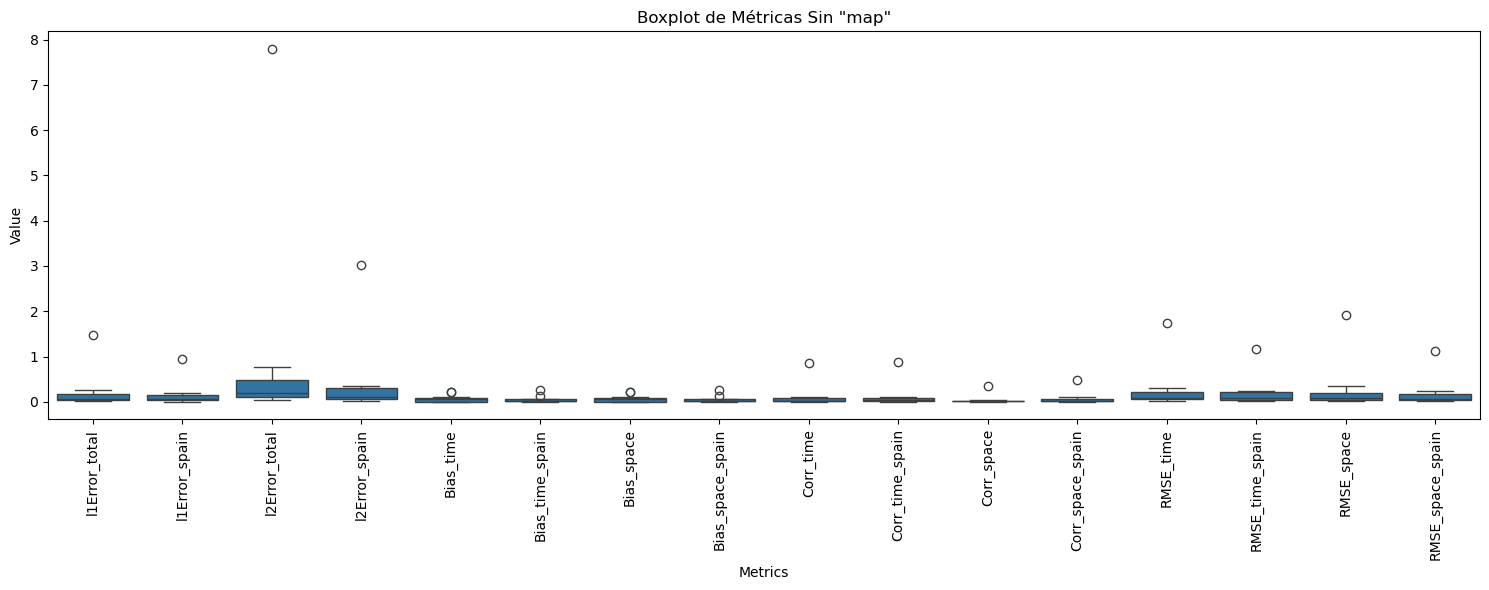

In [22]:
plt.figure(figsize=(15, 6))
sns.boxplot(x="Metric", y="Value", data=metrics_df_filtered)
plt.xticks(rotation=90)
plt.title('Boxplot de Métricas Sin "map"')
plt.xlabel('Metrics')
plt.ylabel('Value')
#plt.ylim([0,1])
plt.tight_layout()
plt.show()

In [23]:
metrics_list = metrics_df_filtered['Metric'].unique()

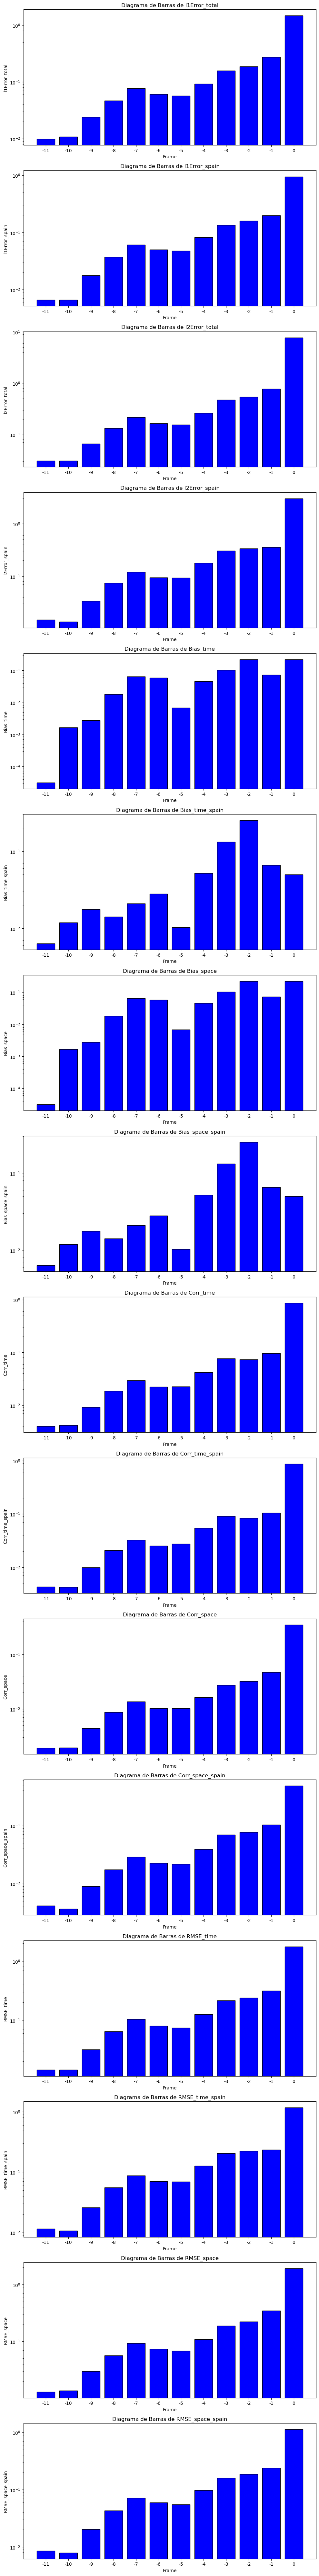

In [32]:
num_metrics = len(metrics_list)

fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 5 * num_metrics))

# Si solo hay un gráfico, lo convertimos a una lista para iterar
if num_metrics == 1:
    axes = [axes]

# Dibujar un barplot para cada métrica
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    metric_data = metrics_df_filtered[metrics_df_filtered['Metric'] == metric]
    
    # Usamos los valores directos (no promediamos)
    frame_values = metric_data['Frame']
    metric_values = metric_data['Value']
        
    # Dibujar las barras
    ax.bar(frame_values, metric_values, color='blue', edgecolor='black')
    
    #ax.set_ylim(bottom=0)
    
    ax.set_title(f'Diagrama de Barras de {metric}')
    ax.set_xlabel('Frame')
    ax.set_ylabel(f'{metric}')
    ax.set_yscale('log')
    ax.set_xticks(frame_values)  # Aseguramos que los frames estén en el eje X
    
# Ajustar el diseño
plt.tight_layout()
plt.show()

#### Visualizing Map Metrics

#### Obtain the map values

In [25]:
# List of interesting metrics
time_metrics_of_interest = ["Bias_map_time", "Corr_map_time", "RMSE_map_time", "Bias_map_time_spain", "Corr_map_time_spain", "RMSE_map_time_spain"]
space_metrics_of_interest = ["Bias_map_space", "Corr_map_space", "RMSE_map_space", "Bias_map_space_spain", "Corr_map_space_spain", "RMSE_map_space_spain"]

frames = list(range(-11, 1)) 

# Create empty lists
time_results = np.zeros((len(time_metrics_of_interest), len(frames), 144, 144))
space_results = np.zeros((len(space_metrics_of_interest), len(frames), 8772))

# time
for i, metric in enumerate(time_metrics_of_interest):
    for j, frame in enumerate(frames):
        key = f"{frame}/{metric}"  
        if key in metrics_diff: #all_metrics:
            time_results[i, j, :] = metrics_diff[key] #all_metrics[key]  

# space
for i, metric in enumerate(space_metrics_of_interest):
    for j, frame in enumerate(frames):
        key = f"{frame}/{metric}"  
        if key in metrics_diff: #all_metrics:
            space_results[i, j, :] = metrics_diff[key] #all_metrics[key]  

# Call data class again to retrive coords.
data = ERA5_dataset()

# Convert to xarray 
time_ds = xr.Dataset({metric: (["frame", "latitude", "longitude"], time_results[i]) for i, metric in enumerate(time_metrics_of_interest)},
    coords={"frame": frames, "latitude": data.input_coords['latitude'], "longitude": data.input_coords['longitude']},
)

# Crear el dataset para 'space'
space_ds = xr.Dataset({metric: (["frame", "time"], space_results[i]) for i, metric in enumerate(space_metrics_of_interest)},
    coords={"frame": frames,"time": data.input_coords['time']})

In [26]:
def plot_time_metric(dataset, metric):
    """
    Plot of the 12 frames given a xarray.Dataset with dimensions (frame, lat, lon).
    
    Parameters:
        dataset (xr.Dataset): Dataset with metrics.
        metric (str): name of the metric.
    """
    if metric not in dataset:
        raise ValueError(f"The metric '{metric}' is not in the dataset.")

    cmap = "viridis"
    extent = [-10.3, 5, 31, 46.4]  
    
    frames = dataset["frame"].values  

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    #vmin, vmax = dataset[metric].min().item(), dataset[metric].max().item()  

    for i, frame in enumerate(frames):            
        ax = axes[i]
        ax.set_extent(extent)
        gls = ax.gridlines(alpha=0.5, draw_labels=True, dms=True)
        gls.right_labels = False
        gls.top_labels = False
        ax.coastlines(resolution='10m')
        
        data = dataset[metric].sel(frame=frame)

        vmin, vmax = data.min().item(), data.max().item()  

        im = ax.pcolormesh(dataset["longitude"], dataset["latitude"], data.values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
        cbar.set_label(label=f'{metric}',size=14, labelpad=10)
        ax.set_title(f'Frame: {frame}')

    # Ajustar diseño
    fig.suptitle(f"Métrica: {metric}", fontsize=16)
    plt.subplots_adjust(right=0.9, top=0.95)
    
    plt.show()

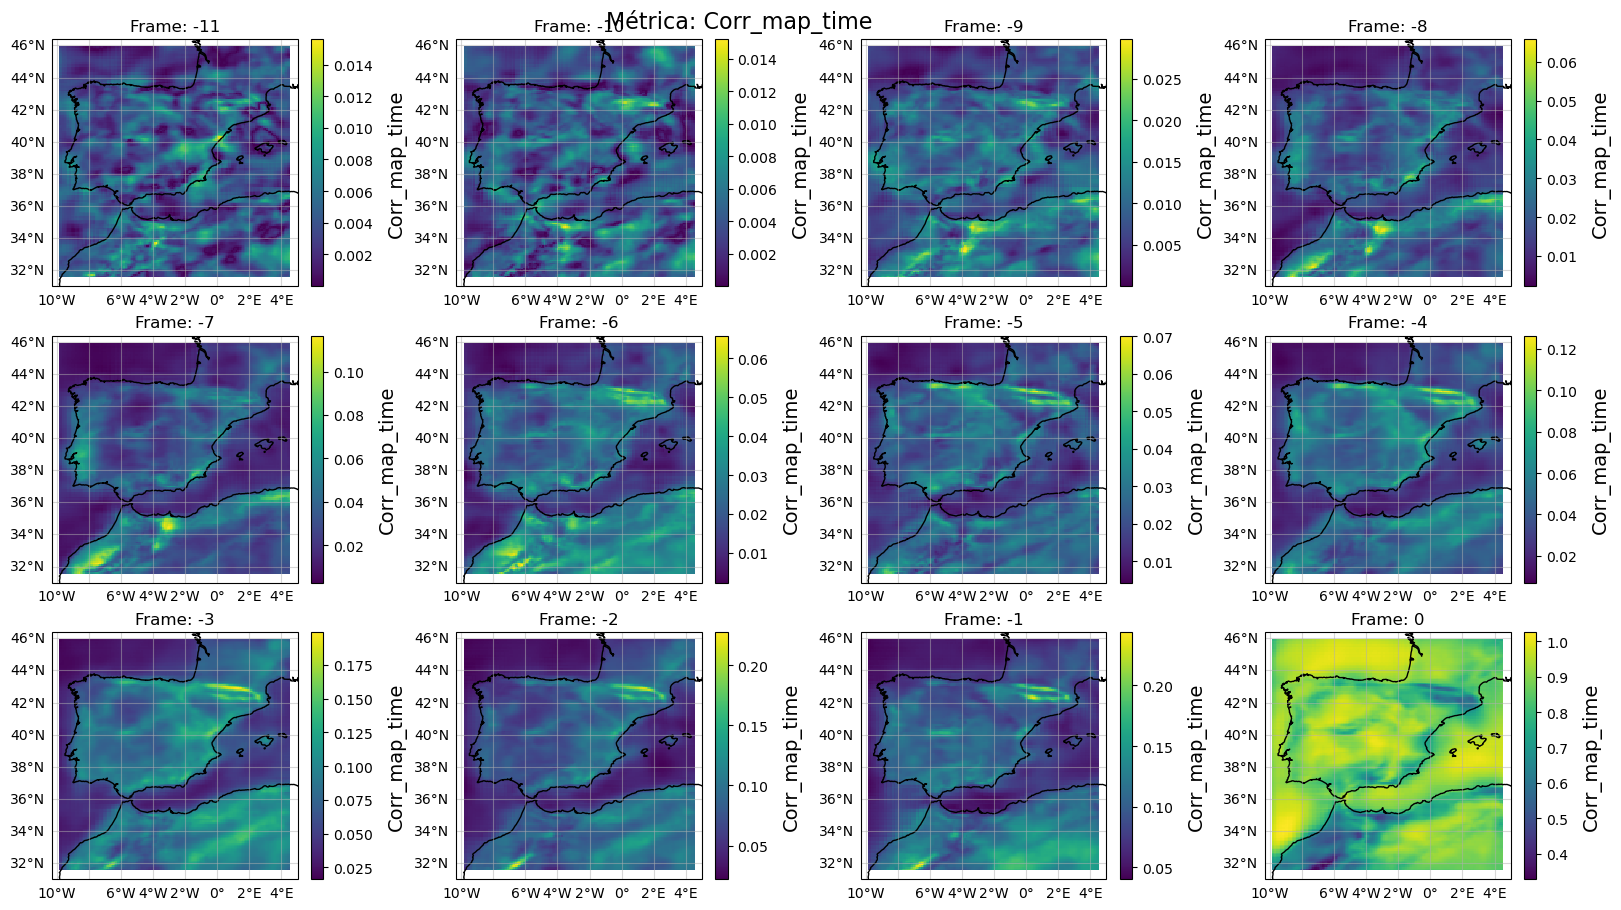

In [27]:
plot_time_metric(time_ds, "Corr_map_time")

In [28]:
import matplotlib.dates as mdates
def plot_space_metric(dataset, metric):
    """
    Plot the 12 frames of a given metric from a spatial xarray.Dataset in 12 subplots.
    
    Parameters:
        dataset (xr.Dataset): Dataset with metrics (dimensions: frame, time).
        metric (str): Name of the metric to plot.
    """
    if metric not in dataset:
        raise ValueError(f"The metric '{metric}' is not in the dataset.")

    frames = dataset["frame"].values  
    time_values = dataset["time"].values  

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, frame in enumerate(frames):
        ax = axes[i]
        data = dataset[metric].sel(frame=frame)
        
        ax.plot(time_values, data, label=f'Frame {frame}')
        ax.set_title(f'Frame {frame}')
        ax.grid(True)

        ax.set_ylabel(metric)
        ax.set_xlabel("Time")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    fig.suptitle(f"Metric vs time: {metric}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()

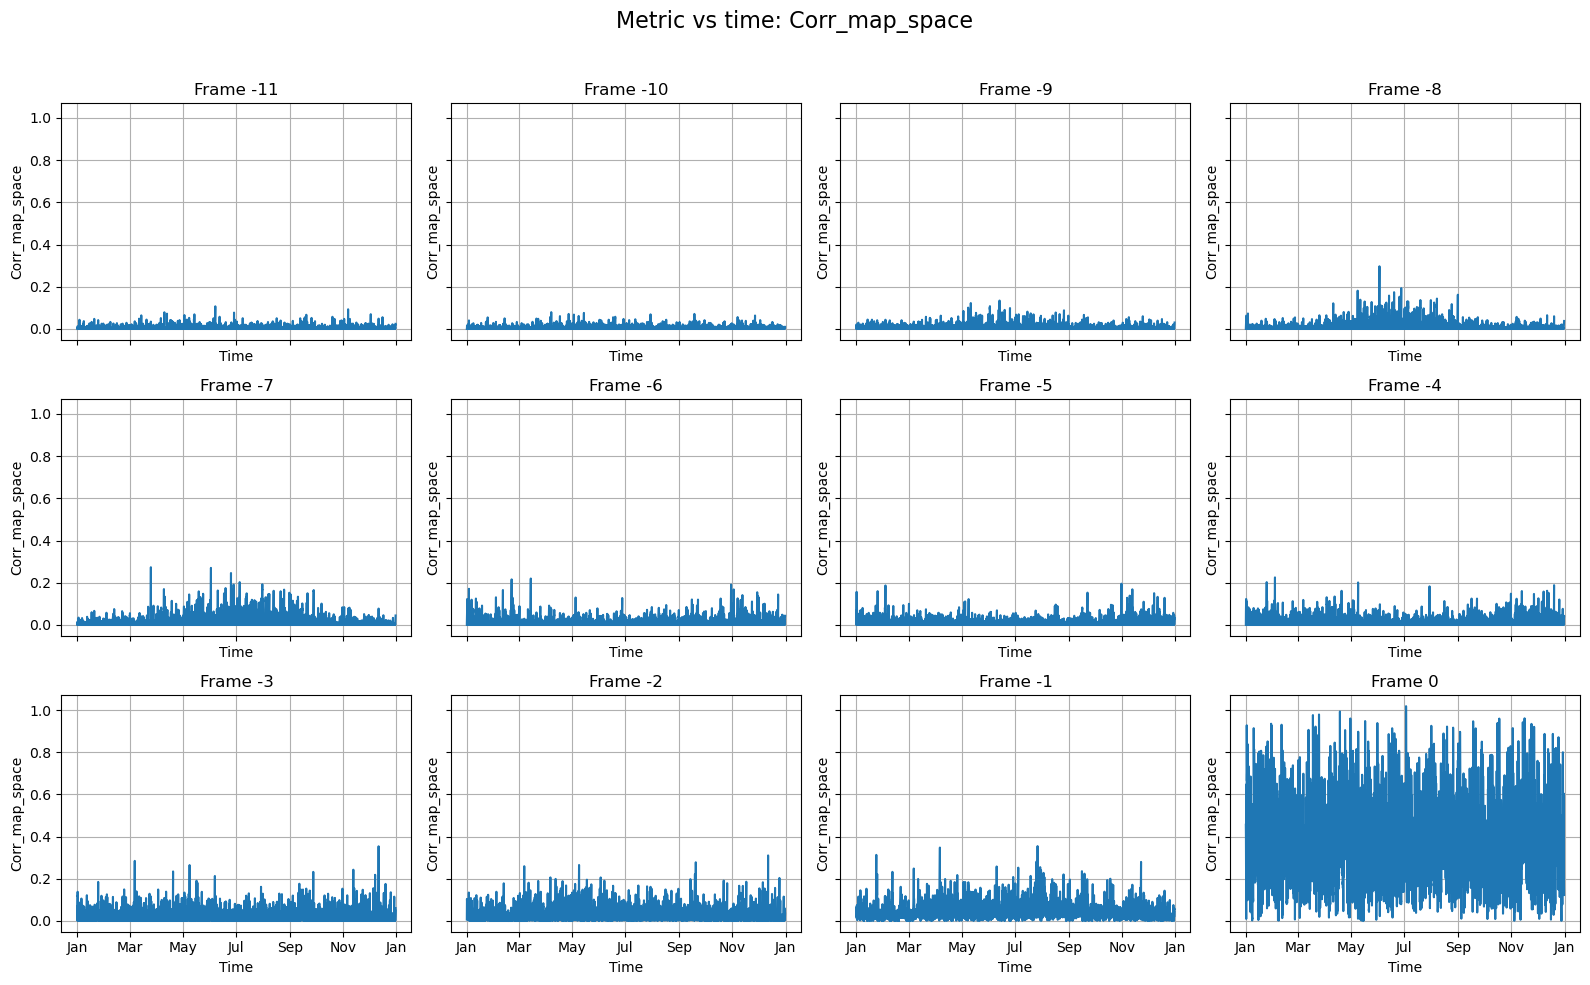

In [34]:
plot_space_metric(space_ds, "Corr_map_space")

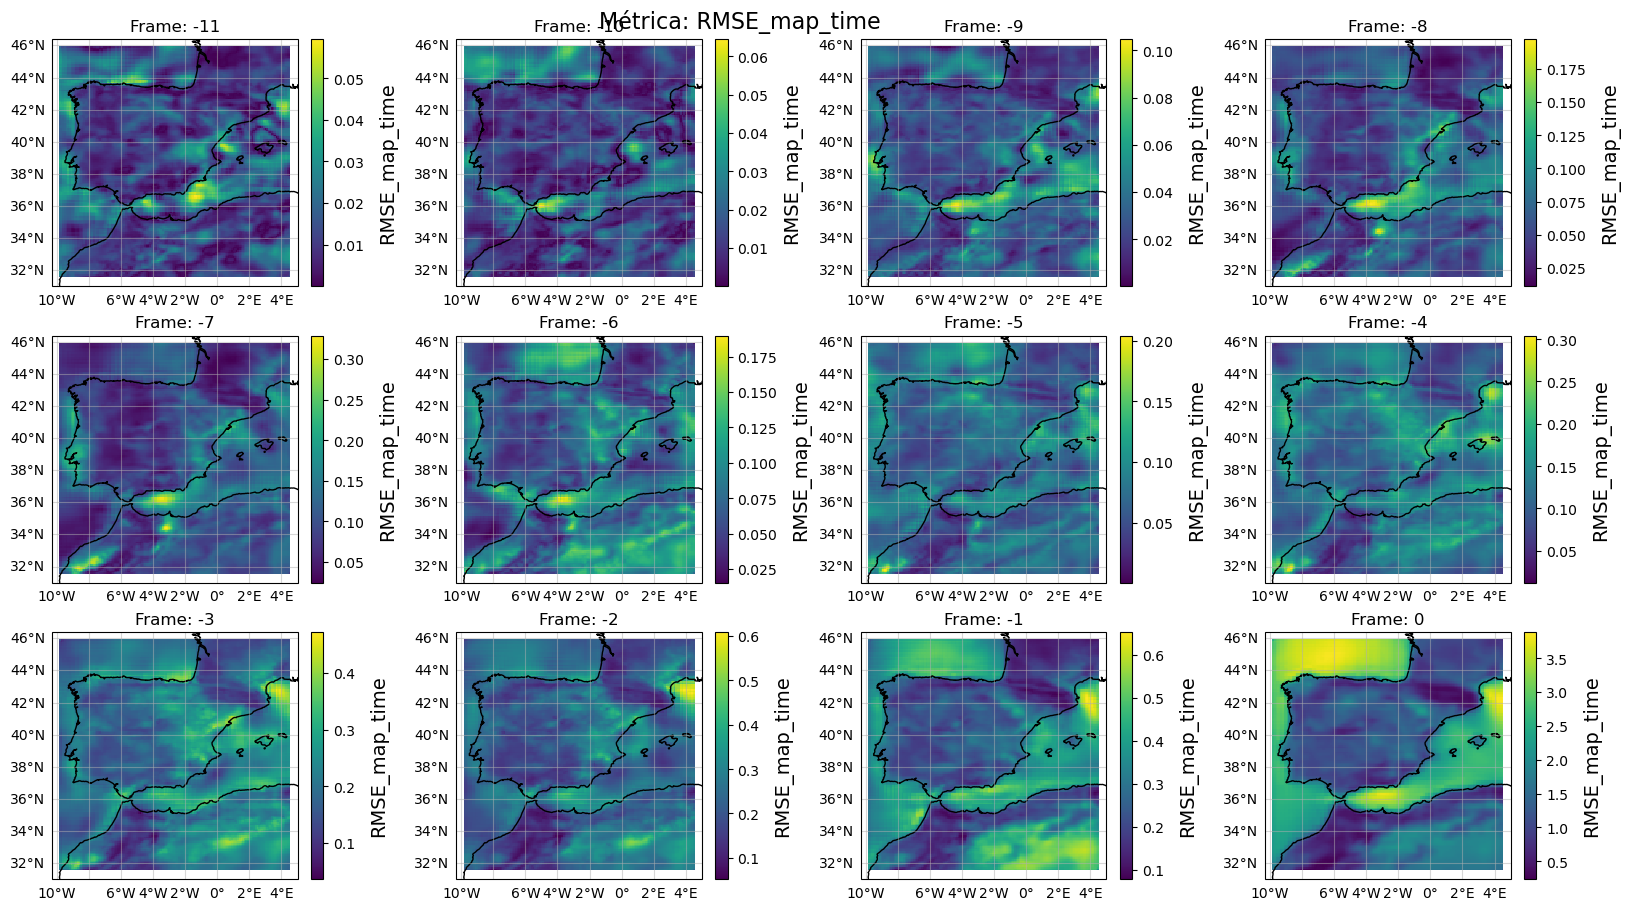

In [35]:
plot_time_metric(time_ds, "RMSE_map_time")

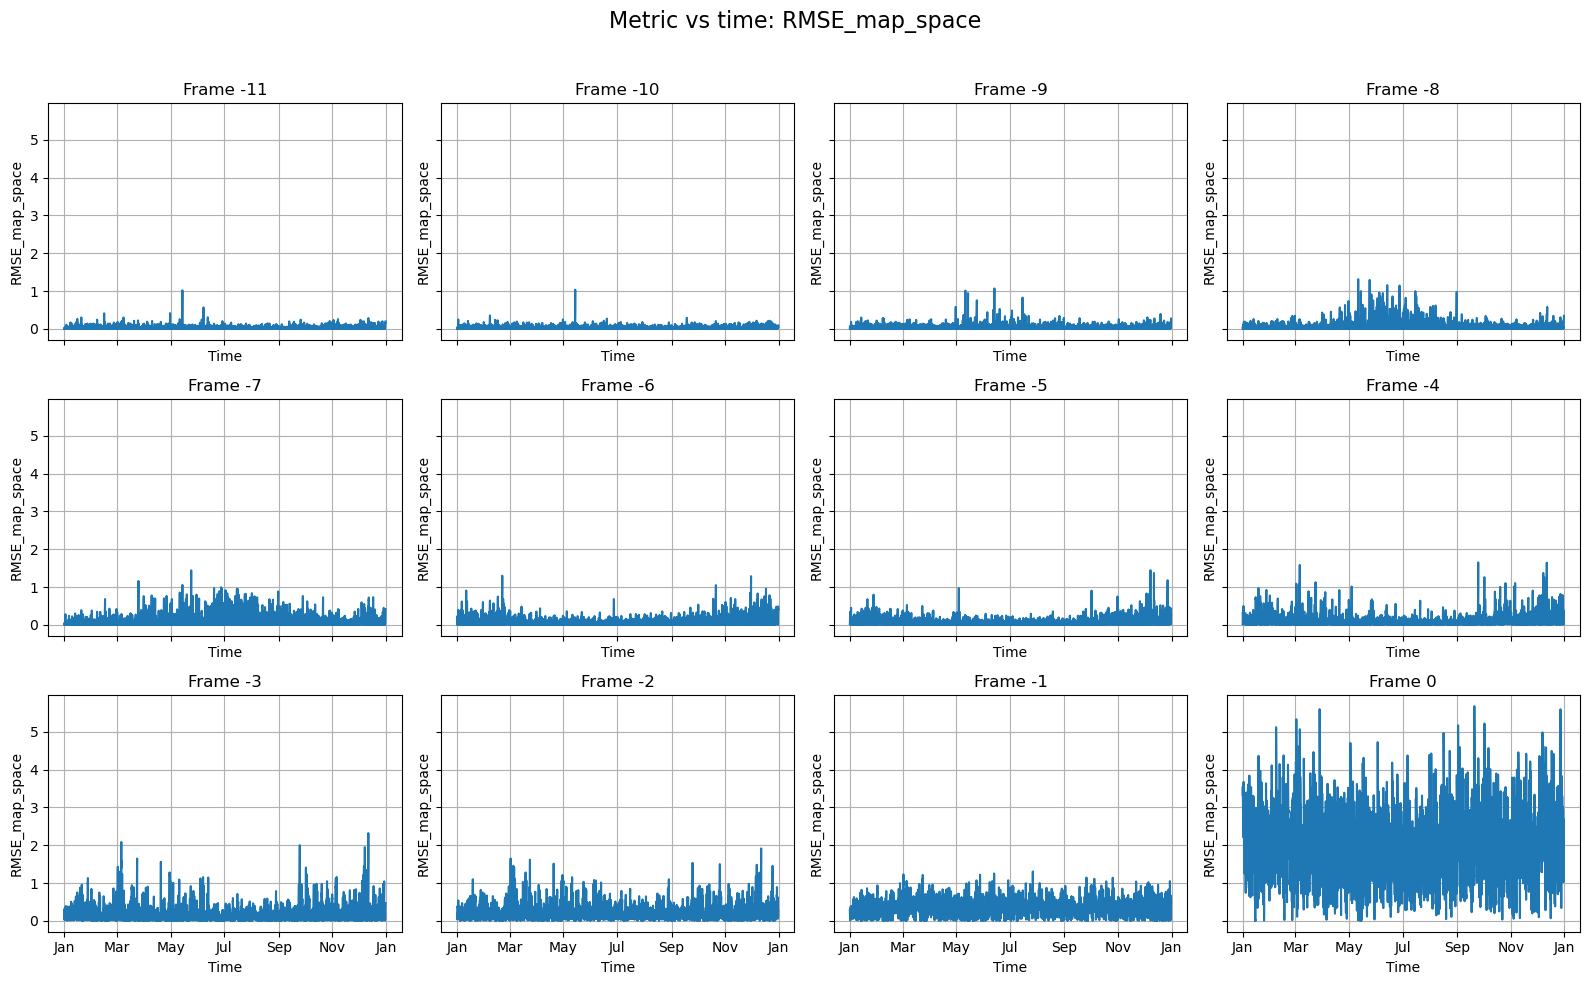

In [36]:
plot_space_metric(space_ds, "RMSE_map_space")